# N-beats model의 이해

- 코드출처 : https://github.com/philipperemy/n-beats/tree/master
- 관련논문 : https://arxiv.org/pdf/1905.10437.pdf?trk=public_post_comment-text


---

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate, Dropout,Subtract
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.callbacks import EarlyStopping
from nbeats_keras.model import NBeatsNet as NBeatsKeras

---

## contributions

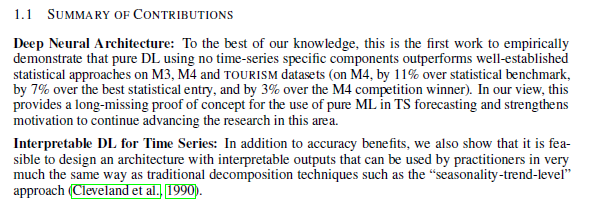

- 순수한 딥러닝 방법이 통계적 접근 방식보다 타임시리즈 예측의 벤치마크가 더 높았음 따라서 time series의 예측을 위한 순수 ML 연구의 동기을 얻을 수 있음
- time seires를 전통적인 분해법과 같은 해석가능한 유연한 딥러닝 아키텍쳐를 제공해주었음

---

## n-beats

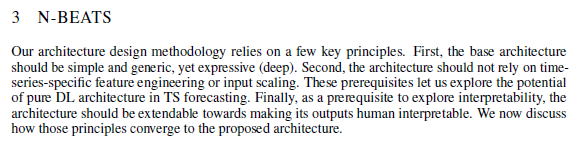

- n-beats의 모델 디자인은 몇가지의 원칙에 의존
    1. 기초 아키텍쳐는 간단하고 generic함
    2. 이 아키텍쳐는 time series의 특정 변수 엔지니어링이나 input scaling에 의존하지 않음ㅈ
    3. 이 아키텍쳐는 해석이 가능하게끔 확장될 수 있음

---

## basic block

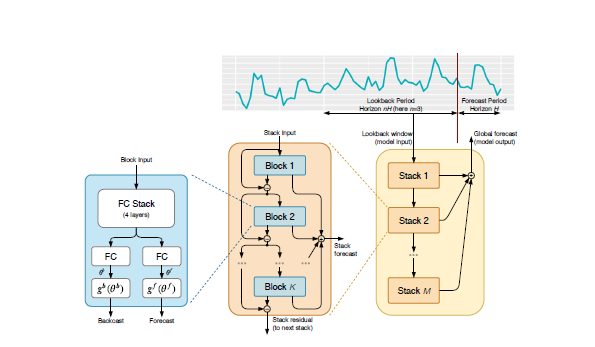
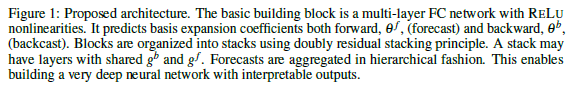

- basic block은 포크 형태의 아키텍쳐를 가짐
- frist block은 특정 길이의 관측된 window만큼의 $x$를 반영함
- multiple of the forecast horizon H만큼의 input window 길이를 설정함 
- block은 input x를 받아들이고 $\hat{x}, \hat{y}$를 output으로 내놓는다
    - $\hat{x}$는 실제 $x$와 가장 잘 추정한 것을 내놓고
    - $\hat{y}$는 블락에서 설정한 H의 길이만큼을 내놓음
- 나머지 블락은 앞서 블락이 내놓은 residual output을 input으로 삼는다.

`-` input x가 first block을 통과하고 다음 블락에게 전달하는 과정
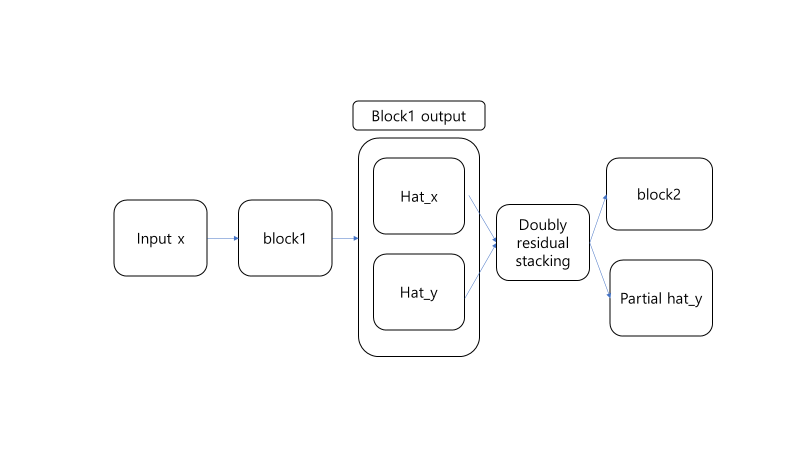)

## `-` basic block

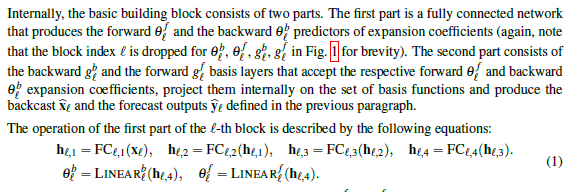

- 베이직 모델은 크게 2개의 part로 구분되어 있다
    - first part(RELU) : fully connnected network로 구성되었고 expansion coefficients의 예측자인 forward $\theta$와 backward $\theta$를 내놓는다
    - second part(Linear) : backward g함수와 forward g함수로 구성되어있어 앞서 첫번째 파트에서 나온 \theta를 받아들이고 최종적으로 output을 내놓는다

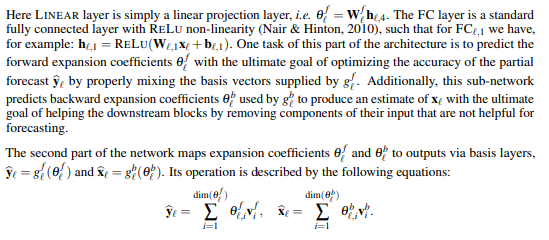

- 선형 레이어
    - $g^f_l$에 의해 제공된 기저벡터를 적절하게 혼합하여 forward expasion coff를 예측
    - 더불어 하위 네트워크는 $g^b_l$에 의해 사용되는 backward expasion coff를 예측하여 x를 추정
    - the downstream blocks에 의해 예측에 도움외 되지 않는 입력 구성 요소를 제거하는 것을 목표

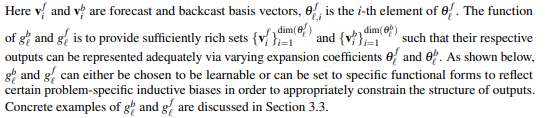

- $v^f_i,v^b_i$ : forecast, backcast basis vectors
- $g^b,g_f $는 풍부한 기저벡터 set를 제공
    - 그들의 반영된 아웃풋은 적절한 다양한 편향을 가진 coff를 잘 나타낼 것임
    - $g^b,g_f $는 배울 수 있게 선택할 수 있고 이는 출력 구조를 적절하게 제약하기 위해 특정 문제에 특화된 귀납적 편향을 반영하기 위한 것

---

## `-` doubly residual stacking

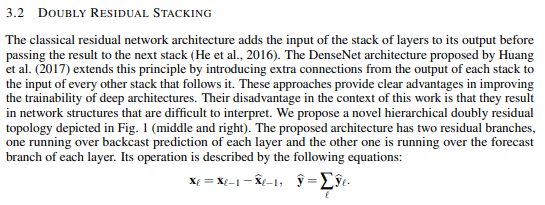

- 고전적인 잔차 네트워크는 레이어의 스택의 인풋에 출력을 더한후 결과를 다음 스택에 전달
- denseNet 아키텍쳐는 각 스택의 출력에서 이를 따르는 모든 스택의 입력으로 추가적인 연결을 도입, 그러나 이런 것은 해석하기 어렵다
- 새로운 계층적 이중 잔차 topology를 제안
    - one : 각 레이어의 backcast 예측
    - two : 각 레이어의 forecast 예측

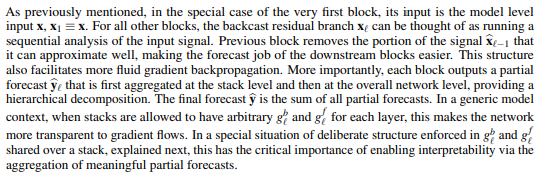

- 첫번째 블락에서 input x는 $x_1 \equiv x$  
- 다른 모든 블락에서 backcast 잔여 브랜치 x는 인풋 신호에 순차적인 분석이라고 볼 수 있다
- 이전 블락에서 the sigmal $\hat{x_{l-1}}$을 잘 근사하는 신호 일부가 삭제됨
- 따라서 하류 블락의 예측 작업이 단순하게 된다
- 이런 구조는 유연한 그래디언트 역전파를 용이하게 함

- **더욱 중요한 것은 각 블록이 먼저 스택 수준에서, 그리고 나중에 전체 네트워크 수준에서 집계한 일부 예측 $\hat{y}$를 출력**
- 최종 예측 $\hat{y}$는 모든 부분 예측의 합계이다.

---

## `-` interpretability

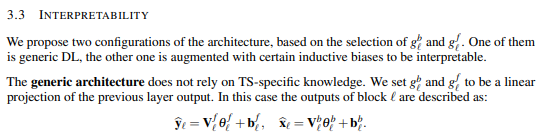

- 두가지를 제안
    - 일반적인 딥러닝
    - 해석가능한 특정한 귀납적 편향이 더해진 구조 모델
- generic achitecture는 일반적인 타임시리즈의 지식에 의존하지 않음

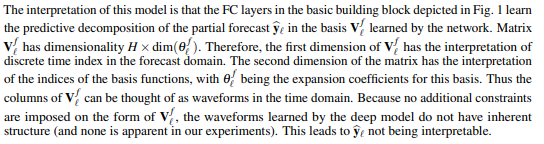

- 이 모델의 해석은 네트워크에서 학습한 기저 벡터의 일부인 $\hat{y}$ 예측의 분해를 학습함
- matrix 기저벡터는 $H \times dim(\theta^f)$의 차원을 가짐
    - 첫번째 차원은 예측 도메인에서 이산 시간의 순서의 해석이라고 볼 수 있다
    - 두번째 차원은 기저 함수들의 지수,시간 도메인에서 파형이라고 볼 수 있다
- 기저벡터의 형태에 대한 추가적인 제약이 없기 때문에 딥모델은 내재된 구조를 갖지않고 파형을 학습함
- 따라서 예측값에 대한 해석이 불가능하다

## `-` 해석가능한 block
### `-` trend model

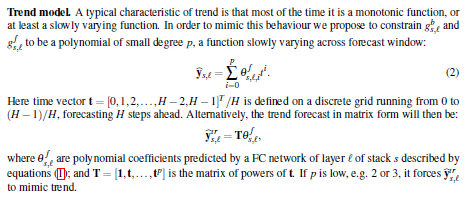


- 가장 단조로운 함수이거나 천천히 변화하는 함수
- 이를 흉내내기위해 작은 차수의 p의 다항식이 되게끔 제한할 것이다.
- forecast에 $t^i$추가 
    - 이는 horizen 만큼의 길이를 가지고 그 값은 horizen로 나눈 값이다
- T는 t의 거듭제곱으로 이루어진 행렬 차수가 낮다면 이는 trend를 흉내낸다

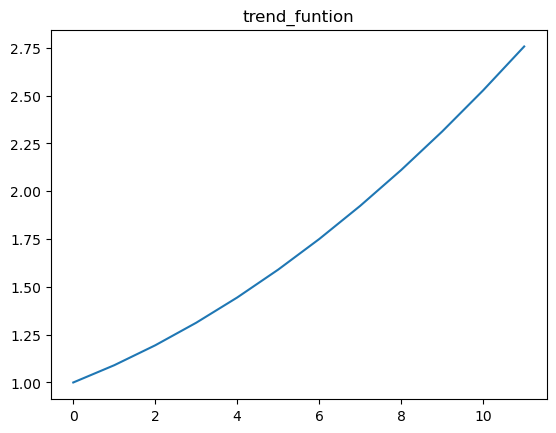

In [20]:
h = 12
t = np.arange(0,h,1)/h
plt.plot(1+t+t**2)
plt.title('trend_funtion')
plt.show()

### `-`Seasonality model.

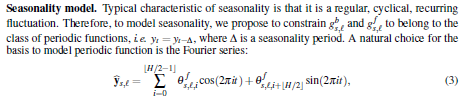

- 계절 주기 성분을 모델에 넣기위해 g함수를 주기 함수와 함께 제한조건을 걸 것임
- 이는 전형적인 계절 패턴을 모방하는 주기적인 함수
- 이렇게 주어진 표현은 시계열 데이터의 계절성을 설명하고, 
- 주기적인 패턴을 표현하기 위해 삼각파 기저 함수를 사용하는 것으로 이해된다.

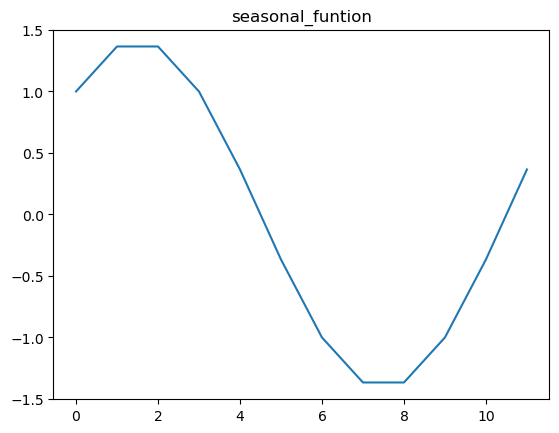

In [34]:
plt.plot(np.cos(2*np.pi*t)+np.sin(2*np.pi*t))
plt.title('seasonal_funtion')
plt.show()

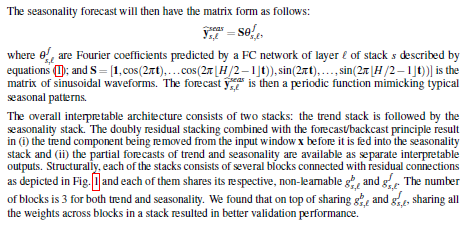

- 해석가능한 아키텍쳐는 traned stack 뒤로 계절성스택이 이어짐
- 이중 잔차 스택은 orecast/ backcast의 원칙과 결합
    1. trend 요소는 계절 스택에 도달하기전에 input window x로부터 삭제됨
    2. 추세와 계절의 부분 예측들은 별도의 해석가능한 output으로 사용가능하다
- 구조적으로 각 스택은 그림 1과 같이 잔차 연결이 연결된 여러 블록으로 구성되며 각 스택은 학습할 수 없는 $g^b_s$' 및 $g^f_s$를 공유
- 블록 수는 추세 및 계절성 모두에 대해 3 
- 우리는 gbs;' 및 gfs;를 공유하는 것 외에도 스택에서 블록 간의 모든 가중치를 공유하면 더 나은 검증 성능을 얻을 수 있음을 발견했다고한다

---

# N-beats 모델

- 모델 적합에 있어 3가지 의문점
    1. 블락의 위치에 따른 성능차이
    2. theta dim 개수 세팅의 당위성
    3. stack의 개수, block의 개수에 따른 성능차이

`-` 연습용 데이터

In [68]:
t = np.linspace(1,10,1000)
X =  t+ np.sin(10*t*np.pi)

class WINdow:
    def __init__(self,df,timestep):
        self.df = df
        self.timestep=timestep+1 # 예상한 timestep보다 1적기 때문에 +1
        
    def window(self):
        for i in range(1, self.timestep):
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
        window_df = self.df.dropna(axis=0) # 결측치 공간 제거
        self.window_df = window_df.iloc[:,::-1] # 좌우 반전
        
                
        self.feature= self.window_df.iloc[:,:-1].values
        self.y_label= self.window_df.iloc[:,-1].values
        
        return self. window_df 

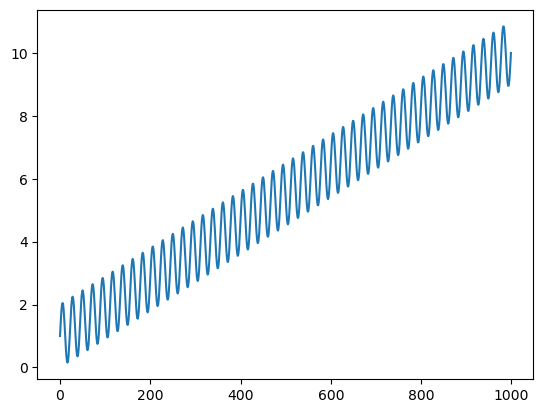

In [103]:
plt.plot(X)

In [95]:
df = pd.DataFrame(X)
x_window = WINdow(df,10)
x_window.window()

In [99]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
scale_X= minmax.fit_transform(x_window.feature) # input
scale_y= minmax.fit_transform(x_window.y_label.reshape(-1, 1)) # putput

from sklearn.model_selection import train_test_split
train_x, test_x, train_y,test_y = train_test_split(scale_X,scale_y,shuffle=False)

train_x.shape, train_y.shape,test_x.shape,test_y.shape

((742, 10), (742, 1), (248, 10), (248, 1))

---

# 계절+추세 데이터 입력 : 블락의 위치 선정

- Q : 추세 블락과 계절 블락의 위치에 따른 모델 성능 차이
    - 같은 조건의 모델을 추세와 계절 블락의 위치를 서로 바꾸어 100번을 독립적으로 훈련한 뒤, 각 훈련 loss의 마지막 인덱스를 추출하여 히스토그램 생성
- 인풋 데이터의 특성에도 차이가 존재할 수 있겠음, 추세성이 강한 데이터, 또는 계절성분이 뚜렷한 데이터에 따라서 블락의 위치 선정에 차이가 있을 수도 있지 않을까

## 추세-계절 모델

In [194]:
time_steps = 10
output_dim = 1
K.clear_session()
nbeatm1 = NBeatsKeras(
        backcast_length=time_steps, forecast_length=output_dim,
        stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.SEASONALITY_BLOCK),
        nb_blocks_per_stack=1, thetas_dim= (10,10), share_weights_in_stack=True,
        hidden_layer_units=64
        )

nbeatm1.summary()

Model: "forecast"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_variable (InputLayer)    [(None, 10, 1)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 10)           0           ['input_variable[0][0]']         
                                                                                                  
 0/0/trend/d1 (Dense)           (None, 64)           704         ['lambda[0][0]']                 
                                                                                                  
 0/0/trend/d2 (Dense)           (None, 64)           4160        ['0/0/trend/d1[0][0]']           
                                                                                           

In [198]:
loss_list = []
for i in range(100):
    K.clear_session()
    
    nbeatm1.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=3, verbose=0, restore_best_weights=True)
    history= nbeatm1.fit(train_x, train_y, validation_data=(test_x, test_y), 
            epochs=5, batch_size=1, callbacks = [early_stop], verbose=0)
    last_loss = history.history['loss'][-1]
    loss_list.append(last_loss)
    

---

## 계절-추세 모델

In [203]:
time_steps = 10
output_dim = 1
K.clear_session()
nbeatm2 = NBeatsKeras(
        backcast_length=time_steps, forecast_length=output_dim,
        stack_types=(NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.TREND_BLOCK),
        nb_blocks_per_stack=1, thetas_dim= (10,10), share_weights_in_stack=True,
        hidden_layer_units=64
        )

In [209]:
loss_list2 = []
for i in range(100):
    K.clear_session()
    
    nbeatm2.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=3, verbose=0, restore_best_weights=True)
    history2= nbeatm2.fit(train_x, train_y, validation_data=(test_x, test_y), 
            epochs=5, batch_size=1, callbacks = [early_stop], verbose=0)
    last_loss2 = history2.history['loss'][-1]
    loss_list2.append(last_loss2)

---

## loss 결과 그래프

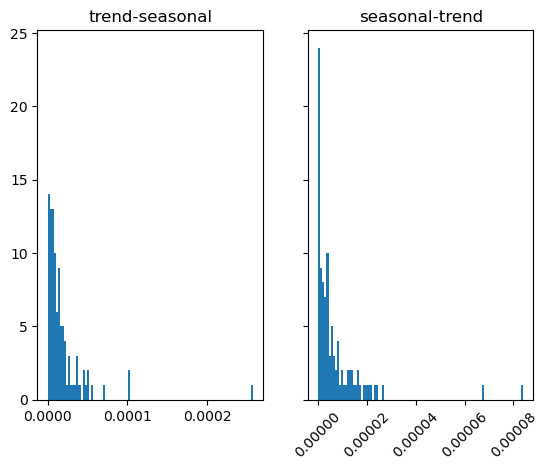

In [275]:
fig, ax = plt.subplots(1,2,sharey=True)
ax[0].hist(loss_list, bins=100);
ax[0].ticklabel_format(style='plain', axis='x')
ax[0].set_title('trend-seasonal')
ax[1].hist(loss_list2, bins=100);
ax[1].ticklabel_format(style='plain', axis='x')
ax[1].set_title('seasonal-trend')
plt.xticks(rotation=45)
plt.show()

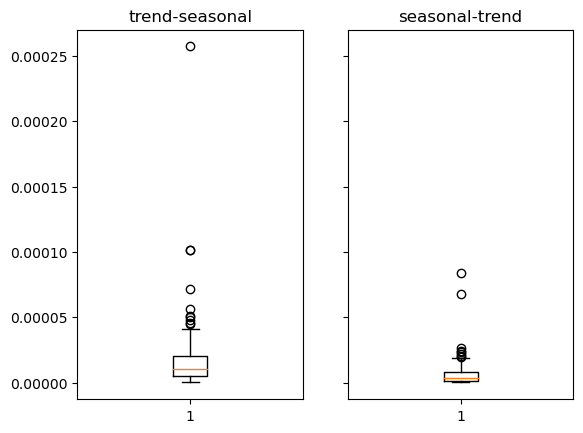

In [239]:
fig, ax = plt.subplots(1,2,sharey=True)
ax[0].boxplot(loss_list)
ax[0].set_title('trend-seasonal')
ax[1].boxplot(loss_list2)
ax[1].set_title('seasonal-trend')
plt.show()

## 각 loss 평균

In [246]:
print('{:.10f}'.format(np.mean(loss_list)))
print('{:.10f}'.format(np.mean(loss_list2)))


0.0000190066
0.0000072581


---

## `-` 추세성 데이터 입력 : 블락 위치 선정

`-` 예시 데이터

In [252]:
t = np.linspace(1,10,1000)

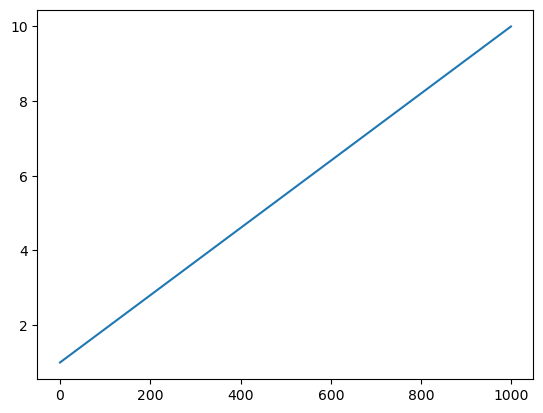

In [254]:
plt.plot(t)

In [262]:
df1 = pd.DataFrame(t)
x_window2 = WINdow(df1,10)
x_window2.window()

,shift_10,shift_9,shift_8,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1,0
10,1.000000,1.009009,1.018018,1.027027,1.036036,1.045045,1.054054,1.063063,1.072072,1.081081,1.090090
11,1.009009,1.018018,1.027027,1.036036,1.045045,1.054054,1.063063,1.072072,1.081081,1.090090,1.099099
12,1.018018,1.027027,1.036036,1.045045,1.054054,1.063063,1.072072,1.081081,1.090090,1.099099,1.108108
13,1.027027,1.036036,1.045045,1.054054,1.063063,1.072072,1.081081,1.090090,1.099099,1.108108,1.117117
14,1.036036,1.045045,1.054054,1.063063,1.072072,1.081081,1.090090,1.099099,1.108108,1.117117,1.126126
...,...,...,...,...,...,...,...,...,...,...,...
995,9.873874,9.882883,9.891892,9.900901,9.909910,9.918919,9.927928,9.936937,9.945946,9.954955,9.963964
996,9.882883,9.891892,9.900901,9.909910,9.918919,9.927928,9.936937,9.945946,9.954955,9.963964,9.972973
997,9.891892,9.900901,9.909910,9.918919,9.927928,9.936937,9.945946,9.954955,9.963964,9.972973,9.981982
998,9.900901,9.909910,9.918919,9.927928,9.936937,9.945946,9.954955,9.963964,9.972973,9.981982,9.990991


In [263]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
scale_X= minmax.fit_transform(x_window2.feature) # input
scale_y= minmax.fit_transform(x_window2.y_label.reshape(-1, 1)) # putput

from sklearn.model_selection import train_test_split
train_x, test_x, train_y,test_y = train_test_split(scale_X,scale_y,shuffle=False)

train_x.shape, train_y.shape,test_x.shape,test_y.shape

((742, 10), (742, 1), (248, 10), (248, 1))

---

## 추세-계절 모델

In [277]:
time_steps = 10
output_dim = 1
K.clear_session()
nbeatm3 = NBeatsKeras(
        backcast_length=time_steps, forecast_length=output_dim,
        stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.SEASONALITY_BLOCK),
        nb_blocks_per_stack=1, thetas_dim= (10,10), share_weights_in_stack=True,
        hidden_layer_units=64
        )

In [278]:

loss_list3 = []
for i in range(100):
    K.clear_session()
    
    nbeatm3.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=3, verbose=0, restore_best_weights=True)
    history3= nbeatm3.fit(train_x, train_y, validation_data=(test_x, test_y), 
            epochs=5, batch_size=1, callbacks = [early_stop], verbose=0)
    last_loss3 = history3.history['loss'][-1]
    loss_list3.append(last_loss3)
    

## 계절-추세 모델

In [309]:
time_steps = 10
output_dim = 1
K.clear_session()
nbeatm4 = NBeatsKeras(
        backcast_length=time_steps, forecast_length=output_dim,
        stack_types=(NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.TREND_BLOCK),
        nb_blocks_per_stack=1, thetas_dim= (10,10), share_weights_in_stack=True,
        hidden_layer_units=64
        )

In [310]:

loss_list4 = []
for i in range(100):
    K.clear_session()
    
    nbeatm4.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=3, verbose=0, restore_best_weights=True)
    history4= nbeatm4.fit(train_x, train_y, validation_data=(test_x, test_y), 
            epochs=5, batch_size=1, callbacks = [early_stop], verbose=0)
    last_loss4 = history4.history['loss'][-1]
    loss_list4.append(last_loss4)
    

---

## loss 결과 그래프

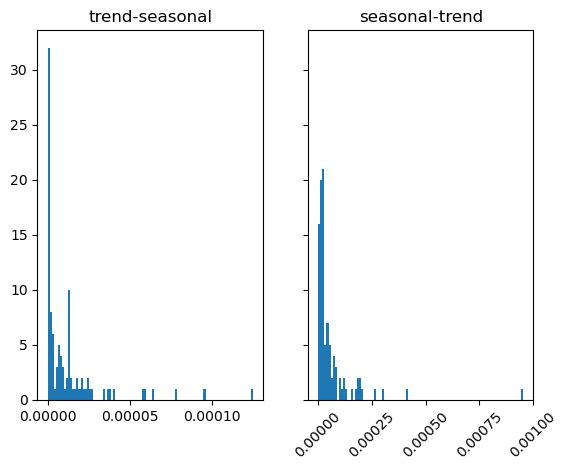

In [311]:
fig, ax = plt.subplots(1,2,sharey=True)
ax[0].hist(loss_list3, bins=100);
ax[0].ticklabel_format(style='plain', axis='x')
ax[0].set_title('trend-seasonal')
ax[1].hist(loss_list4, bins=100);
ax[1].ticklabel_format(style='plain', axis='x')
ax[1].set_title('seasonal-trend')
plt.xticks(rotation=45)
plt.show()

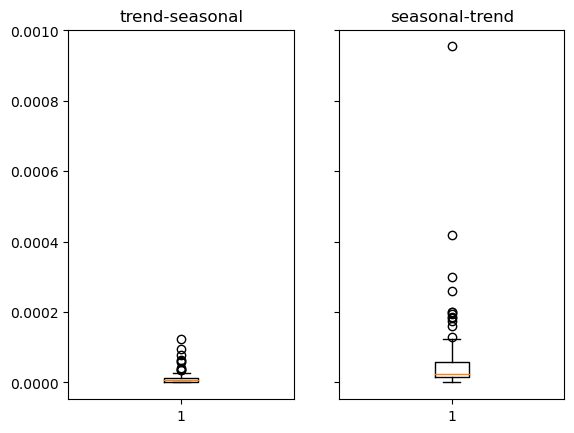

In [312]:
fig, ax = plt.subplots(1,2,sharey=True)
ax[0].boxplot(loss_list3)
ax[0].set_title('trend-seasonal')
ax[1].boxplot(loss_list4)
ax[1].set_title('seasonal-trend')
plt.show()

In [313]:
print('{:.10f}'.format(np.mean(loss_list3)))
print('{:.10f}'.format(np.mean(loss_list4)))


0.0000126824
0.0000621010


---

## `-` 추세성 데이터 입력 : 블락 위치 선정

`-` 예제데이터

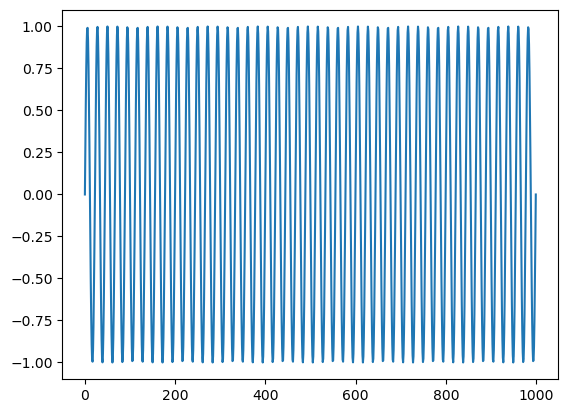

In [290]:
X =  np.sin(10*t*np.pi)
plt.plot(X)

In [291]:
df2 = pd.DataFrame(X)
x_window3 = WINdow(df2,10)
x_window3.window()

,shift_10,shift_9,shift_8,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1,0
10,-1.224647e-15,0.279263,0.536305,0.750672,0.905308,0.987909,0.991900,0.916966,0.769068,0.559975,3.063240e-01
11,2.792629e-01,0.536305,0.750672,0.905308,0.987909,0.991900,0.916966,0.769068,0.559975,0.306324,2.829886e-02
12,5.363046e-01,0.750672,0.905308,0.987909,0.991900,0.916966,0.769068,0.559975,0.306324,0.028299,-2.519781e-01
13,7.506723e-01,0.905308,0.987909,0.991900,0.916966,0.769068,0.559975,0.306324,0.028299,-0.251978,-5.122049e-01
14,9.053085e-01,0.987909,0.991900,0.916966,0.769068,0.559975,0.306324,0.028299,-0.251978,-0.512205,-7.316753e-01
...,...,...,...,...,...,...,...,...,...,...,...
995,7.316753e-01,0.512205,0.251978,-0.028299,-0.306324,-0.559975,-0.769068,-0.916966,-0.991900,-0.987909,-9.053085e-01
996,5.122049e-01,0.251978,-0.028299,-0.306324,-0.559975,-0.769068,-0.916966,-0.991900,-0.987909,-0.905308,-7.506723e-01
997,2.519781e-01,-0.028299,-0.306324,-0.559975,-0.769068,-0.916966,-0.991900,-0.987909,-0.905308,-0.750672,-5.363046e-01
998,-2.829886e-02,-0.306324,-0.559975,-0.769068,-0.916966,-0.991900,-0.987909,-0.905308,-0.750672,-0.536305,-2.792629e-01


In [292]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
scale_X= minmax.fit_transform(x_window3.feature) # input
scale_y= minmax.fit_transform(x_window3.y_label.reshape(-1, 1)) # putput

from sklearn.model_selection import train_test_split
train_x, test_x, train_y,test_y = train_test_split(scale_X,scale_y,shuffle=False)

train_x.shape, train_y.shape,test_x.shape,test_y.shape

((742, 10), (742, 1), (248, 10), (248, 1))

## 추세-계절 모델

In [294]:
time_steps = 10
output_dim = 1
K.clear_session()
nbeatm5= NBeatsKeras(
        backcast_length=time_steps, forecast_length=output_dim,
        stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.SEASONALITY_BLOCK),
        nb_blocks_per_stack=1, thetas_dim= (10,10), share_weights_in_stack=True,
        hidden_layer_units=64
        )

In [297]:

loss_list5= []
for i in range(100):
    K.clear_session()
    
    nbeatm5.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=3, verbose=0, restore_best_weights=True)
    history5= nbeatm5.fit(train_x, train_y, validation_data=(test_x, test_y), 
            epochs=5, batch_size=1, callbacks = [early_stop], verbose=0)
    last_loss5 = history5.history['loss'][-1]
    loss_list5.append(last_loss5)
    

---

## 계절-추세 모델

In [304]:
time_steps = 10
output_dim = 1
K.clear_session()
nbeatm6= NBeatsKeras(
        backcast_length=time_steps, forecast_length=output_dim,
        stack_types=(NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.TREND_BLOCK),
        nb_blocks_per_stack=1, thetas_dim= (10,10), share_weights_in_stack=True,
        hidden_layer_units=64
        )

In [305]:

loss_list6= []
for i in range(100):
    K.clear_session()
    
    nbeatm6.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=3, verbose=0, restore_best_weights=True)
    history6= nbeatm6.fit(train_x, train_y, validation_data=(test_x, test_y), 
            epochs=5, batch_size=1, callbacks = [early_stop], verbose=0)
    last_loss6 = history6.history['loss'][-1]
    loss_list6.append(last_loss6)
    

## loss 결과 그래프

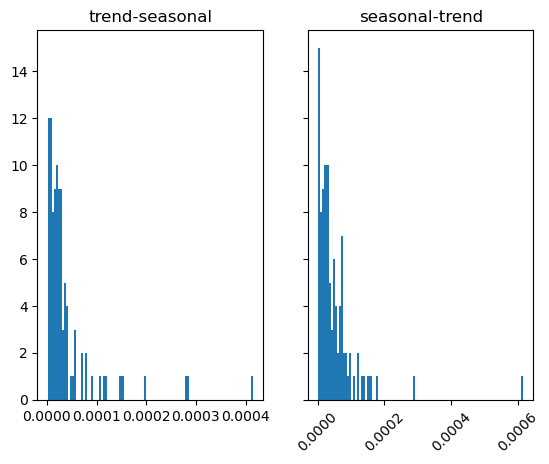

In [306]:
fig, ax = plt.subplots(1,2,sharey=True)
ax[0].hist(loss_list5, bins=100);
ax[0].ticklabel_format(style='plain', axis='x')
ax[0].set_title('trend-seasonal')
ax[1].hist(loss_list6, bins=100);
ax[1].ticklabel_format(style='plain', axis='x')
ax[1].set_title('seasonal-trend')
plt.xticks(rotation=45)
plt.show()

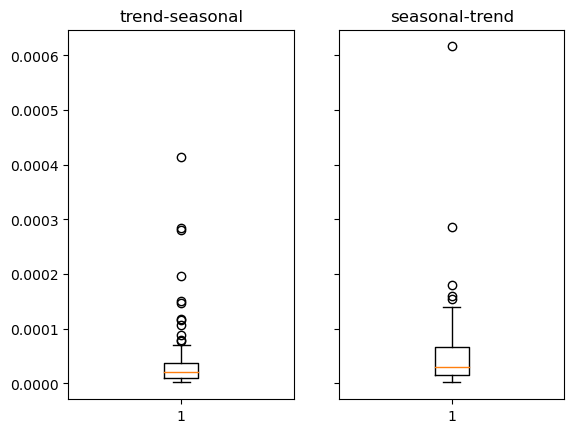

In [307]:
fig, ax = plt.subplots(1,2,sharey=True)
ax[0].boxplot(loss_list5)
ax[0].set_title('trend-seasonal')
ax[1].boxplot(loss_list6)
ax[1].set_title('seasonal-trend')
plt.show()

In [308]:
print('{:.10f}'.format(np.mean(loss_list5)))
print('{:.10f}'.format(np.mean(loss_list6)))


0.0000398360
0.0000514229


## `-` **정리**
- nbeats 모델의 추세와 계절 블락의 위치에 따라 loss차이가 발생하는 것으로 보인다
- 추세 + 계절 성분의 데이터에서 계절 블락을 앞세운 모델이 평균 loss가 더 적었다
- 추세 성분의 데이터에서도 추세블락을 앞세운 모델이 압도적으로 평균 loss가 더 적었다
- 계절 성분의 데이터에서는 추세블락을 앞세운 모델이 평균 loss가 더 적었다
- **단 theta의 차원 개수 지정을 고려하지 않아서 이부분에 대한 추가적인 고민이 필요해보임**

---

## generic block 구현(미완)

### `-` generic block model

In [128]:
backcast_length,horizen = 10,10
feature1 = 10
unit = 128
theta_dim1,theta_dim2= 2,2
forecast_length = 1

K.clear_session()
#input_x_ = Input(shape=(backcast_length,feature1 ))
d0 = Input(shape=(feature1,horizen))
d1 = Dense(unit,activation = 'relu')(d0)
d2 = Dense(unit,activation = 'relu')(d1)
d3 = Dense(unit,activation = 'relu')(d2)
d4 = Dense(unit,activation = 'relu')(d3)

theta_b = Dense(theta_dim1, activation='linear', name='theta_b')(d4)
theta_f = Dense(theta_dim2, activation='linear',  name='theta_f')(d4)

backcast = Dense(backcast_length, activation='linear', use_bias=False,name='backcast')(theta_b)
forecast = Dense(forecast_length, activation='linear', use_bias=False,name='forecast')(theta_f)




block = Model(inputs=d0,outputs = [backcast,forecast])
optimizer = Adam(learning_rate=0.0001)
block.compile(optimizer=optimizer,loss='mean_squared_error')
#subtract_M.compile(optimizer=optimizer,loss='mean_squared_error')
block.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 10)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 10, 128)      1408        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 10, 128)      16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 10, 128)      16512       ['dense_1[0][0]']                
                                                                                              

In [129]:
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=0)
epochs = 50
batch_size = 2

block.fit(train_x,[train_x,train_y], epochs=epochs, batch_size=0,callbacks=[early_stop])
          

Epoch 1/50
24/24 [==============================] - 0s 1ms/step - loss: 0.3448 - backcast_loss: 0.1863 - forecast_loss: 0.1585
Epoch 2/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2243 - backcast_loss: 0.1760 - forecast_loss: 0.0483
Epoch 3/50
24/24 [==============================] - 0s 997us/step - loss: 0.1691 - backcast_loss: 0.1596 - forecast_loss: 0.0094
Epoch 4/50
24/24 [==============================] - 0s 1ms/step - loss: 0.1489 - backcast_loss: 0.1438 - forecast_loss: 0.0050
Epoch 5/50
24/24 [==============================] - 0s 997us/step - loss: 0.1389 - backcast_loss: 0.1359 - forecast_loss: 0.0030
Epoch 6/50
24/24 [==============================] - 0s 1ms/step - loss: 0.1344 - backcast_loss: 0.1327 - forecast_loss: 0.0017
Epoch 7/50
24/24 [==============================] - 0s 1ms/step - loss: 0.1315 - backcast_loss: 0.1303 - forecast_loss: 0.0012
Epoch 8/50
24/24 [==============================] - 0s 1ms/step - loss: 0.1291 - backcast_loss: 0.1281 - fo

In [130]:
pred_x = block.predict(train_x)

24/24 [==============================] - 0s 726us/step


## `-` backcast / x

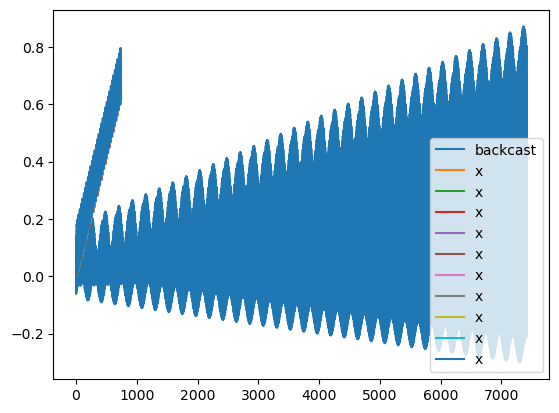

In [131]:
plt.plot(pred_x[0].flatten(), label='backcast')
plt.plot(train_x,label='x')
plt.legend() 
plt.show()

## `-` forecast / y

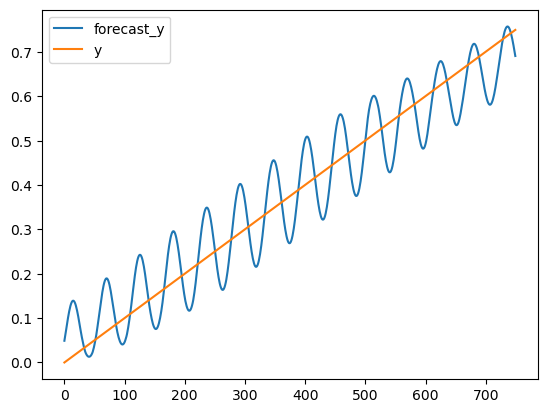

In [46]:
plt.plot(pred_x[1].flatten(),label='forecast_y')
plt.plot(train_y,label='y')
plt.legend() 
plt.show()

In [167]:
input_x = Input(shape=(horizen , feature1))
back_x = Input(shape=(horizen , feature1))
subtract1 =Subtract()([input_x, back_x])
subtract_M = Model(inputs=[input_x,back_x],outputs =subtract1  )
subtract_M.compile(optimizer=optimizer,loss='mean_squared_error')
subtract_M.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                                  
 subtract_1 (Subtract)          (None, 1, 1)         0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
Total params: 0
Trainable params: 0
Non-trainable params: 0
________________________________

In [168]:
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=0)
epochs = 50
batch_size = 2

subtract_M.fit([train_x,pred[0].reshape(750,1)],train_x,
               epochs=epochs, batch_size=2,callbacks=[early_stop])

Epoch 1/50
375/375 [==============================] - 0s 553us/step - loss: 0.2003
Epoch 2/50
375/375 [==============================] - 0s 552us/step - loss: 0.2003
Epoch 3/50
375/375 [==============================] - 0s 547us/step - loss: 0.2003
Epoch 4/50
375/375 [==============================] - 0s 549us/step - loss: 0.2003
Epoch 5/50
375/375 [==============================] - 0s 549us/step - loss: 0.2003
Epoch 6/50
375/375 [==============================] - 0s 553us/step - loss: 0.2003
Epoch 7/50
375/375 [==============================] - 0s 557us/step - loss: 0.2003
Epoch 8/50
375/375 [==============================] - 0s 552us/step - loss: 0.2003
Epoch 9/50
375/375 [==============================] - 0s 560us/step - loss: 0.2003
Epoch 10/50
375/375 [==============================] - 0s 555us/step - loss: 0.2003
Epoch 11/50
375/375 [==============================] - 0s 549us/step - loss: 0.2003


In [172]:
pred_x_sub = subtract_M.predict([train_x,pred[0].reshape(750,1)]) 

24/24 [==============================] - 0s 564us/step


## `-` doubly resudual stack x

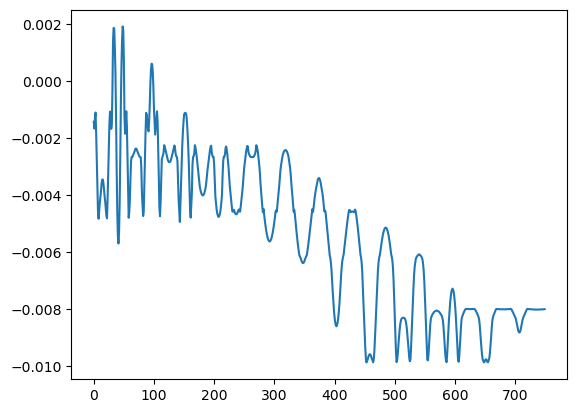

In [173]:
plt.plot(pred_x_sub.flatten())

---